# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Collection

### Note: Some price series are not available on non-business days, hence there will be an issue with NaNs. 
### Ideally, we should drop all weekends and holidays 

In [2]:
# Loading the data
VIX_raw = pd.read_csv('data/VIX.csv', header = 2)
DOW_raw = pd.read_csv('data/DOW.csv', header = 2)
GFD_raw = pd.read_csv('data/GFD_TBILL_DAILY.csv', header = 2)
GOLD_raw = pd.read_csv('data/GOLD.csv', header = 2)
SPX_raw = pd.read_csv('data/SPX.csv', header = 2)
# I'm not using US_10YR because it contains duplicate values for many dates
#US_10YR = pd.read_csv('data/US_10yr_yield.csv', header = 2)

In [3]:
# Define a helper function to process the data
def process_data(df, label, feature_engineering = True):
    
    # Convert the Date column from a string to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Get only the Dates earlier than 2021-10-21 since we aren't predicting into the future
    df = df.loc[(df['Date'] <= '2021-10-21')]
    
    # Carries forward old prices, so we aren't using future information
    df.fillna(method = 'ffill', inplace=True) 
    
    # Drop the 'Ticker' and 'Open' columns
    df = df.drop(columns = ['Ticker', 'Open'], axis=1)
    
    # Take percentage changes
    if feature_engineering == True:
        
        # Grab percentage changes in price
        percentage_changes = df.loc[:, 'Close'].pct_change()
        
        # Daily percentage change feature
        df[label+"_pct_change"] = percentage_changes
        
        # Rolling volatility feature
        long_term_vol = percentage_changes.std()
        rolling_vol_30_day = percentage_changes.rolling(window=30).std() / long_term_vol
        rolling_vol_10_day = percentage_changes.rolling(window=10).std() / long_term_vol
        df[label+"_rolling_vol_30D"] = rolling_vol_30_day
        df[label+"_rolling_vol_10D"] = rolling_vol_10_day
        
    else:
        # Just label the closing price column with passed label
        df[label] = df.loc[:,'Close']
    
    # Reverse the data to go backward in time
    df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    # Rename the 'Close' column with the passed label
    #df = df.rename(columns={'Close': label})
    df = df.drop(columns = 'Close')
    
    return df

# Process all of the data
VIX = process_data(VIX_raw, 'VIX', feature_engineering = False) # We predict raw VIX levels.
DOW = process_data(DOW_raw, 'DOW')
GFD = process_data(GFD_raw, 'TBILL')
GOLD = process_data(GOLD_raw, 'GOLD')
SPX = process_data(SPX_raw, 'SPX')
#US_10YR = process_data(US_10YR, 'US_10YR')

# Process all the data without feature engineering for visualization
DOW_raw = process_data(DOW_raw, 'DOW', feature_engineering = False)
GFD_raw = process_data(GFD_raw, 'TBILL', feature_engineering = False)
GOLD_raw = process_data(GOLD_raw, 'GOLD', feature_engineering = False)
SPX_raw = process_data(SPX_raw, 'SPX', feature_engineering = False)
#US_10YR = process_data(US_10YR, 'US_10YR', feature_engineering = False)


# Merge all of the data into one large dataframe
from functools import reduce

dfs = [VIX, DOW, GFD, GOLD, SPX]
#dfs = [VIX, DOW, GFD, GOLD, SPX, US_10YR]
data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dfs)

dfs_raw = [VIX, DOW_raw, GFD_raw, GOLD_raw, SPX_raw]
#dfs_raw = [VIX, DOW_raw, GFD_raw, GOLD_raw, SPX_raw, US_10YR_raw]
data_raw = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dfs_raw)

# Sort the data by descending date
data = data.sort_values(by='Date', ascending=False).reset_index(drop=True)
data_raw = data_raw.sort_values(by='Date', ascending=False).reset_index(drop=True)

# Absent values should have percentage changes of zero. 
# But we want to front-fill the VIX volumn
data.loc[:, 'VIX'] = data.loc[:,'VIX'].fillna(method='bfill') # Use old VIX values to fill nans in the future.
data_raw = data_raw.fillna(method='bfill')

# Everything remaining we can just fill with zero.
data = data.fillna(value = 0.0)

data

,Date,VIX,DOW_pct_change,DOW_rolling_vol_30D,DOW_rolling_vol_10D,TBILL_pct_change,TBILL_rolling_vol_30D,TBILL_rolling_vol_10D,GOLD_pct_change,GOLD_rolling_vol_30D,GOLD_rolling_vol_10D,SPX_pct_change,SPX_rolling_vol_30D,SPX_rolling_vol_10D
0,2021-10-21,15.01,-0.000176,0.848682,0.639111,0.000002,0.004717,0.002501,0.000000,0.000000,0.000000,0.003069,0.420098,0.307508
1,2021-10-20,15.49,0.004288,0.852996,0.667375,0.000001,0.004775,0.002501,-0.000871,0.664157,0.647277,0.003675,0.421592,0.316524
2,2021-10-19,15.70,0.005636,0.851480,0.666866,0.000001,0.004783,0.002450,0.006618,0.677248,0.647946,0.007408,0.420680,0.316498
3,2021-10-18,16.31,-0.001024,0.856863,0.686900,0.000002,0.004785,0.002292,-0.002708,0.685247,0.632609,0.003375,0.416579,0.328336
4,2021-10-17,16.30,0.000000,0.000000,0.000000,0.000002,0.004609,0.002450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84264,1791-02-05,0.00,0.000000,0.000000,0.000000,0.000164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
84265,1791-02-04,0.00,0.000000,0.000000,0.000000,0.000164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
84266,1791-02-03,0.00,0.000000,0.000000,0.000000,0.000164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
84267,1791-02-02,0.00,0.000000,0.000000,0.000000,0.000164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Data Visualization

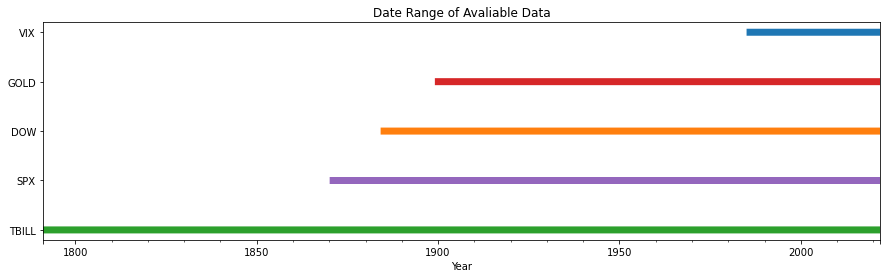

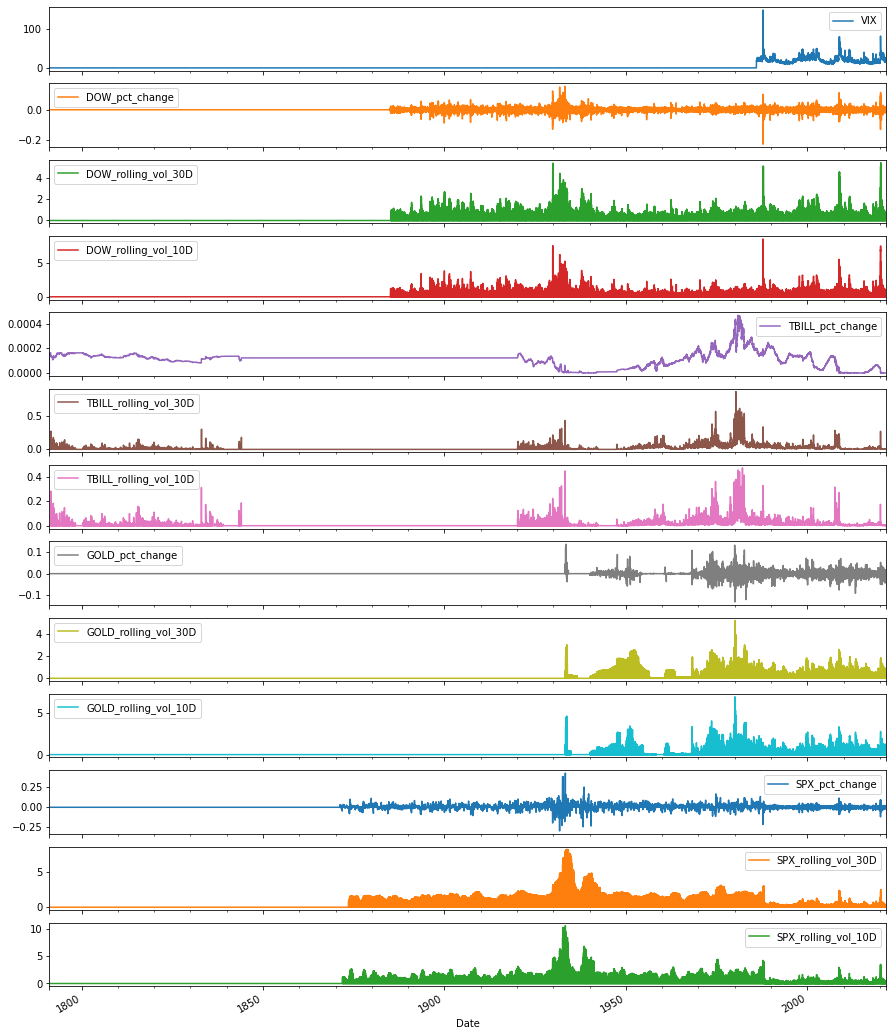

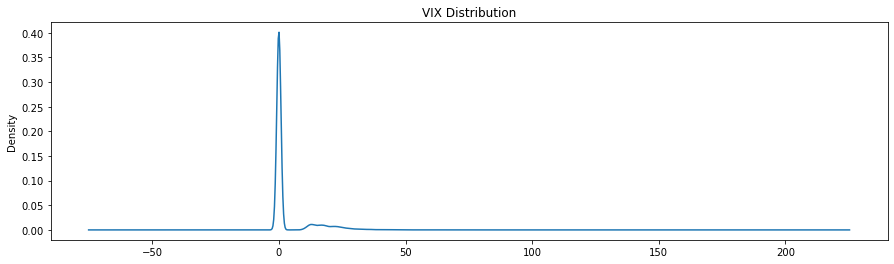

In [4]:
# Plot the date range that data is available for each 
newdf = data_raw
newdf['TBILL'] = newdf['TBILL']/newdf['TBILL']*1
newdf['SPX'] = newdf['SPX']/newdf['SPX']*2
newdf['DOW'] = newdf['DOW']/newdf['DOW']*3
newdf['GOLD'] = newdf['GOLD']/newdf['GOLD']*4
newdf['VIX'] = newdf['VIX']/newdf['VIX']*5
newdf.plot('Date', figsize = (15,4), legend=None, title = 'Date Range of Avaliable Data',linewidth=7.0)
plt.yticks([1,2,3,4,5], ['TBILL', 'SPX', 'DOW', 'GOLD', 'VIX'])
plt.xlabel('Year')
#plt.savefig('Available_Data.png')
plt.show()

# Plot all of the columns vs the Date
data.plot('Date', subplots=True, figsize = (15,20))
plt.show()

# Plot the distribution of the VIX data
data['VIX'].plot(kind = 'kde', figsize = (15,4), title = 'VIX Distribution')
plt.show()